<a id='home'></a>

# Modelo de crédito para pessoa física

## Conteúdo

- [Análise exploratória dos dados](#explora)
- [Pré-processamento, limpeza, e remoção de dados](#dataprep)
- [Modelos de classificação](#modelo)
  - [Modelo de processamento de texto](#texto)
  - [Modelo para as variáveis numéricas](#numer)
  - [Modelo para as variáveis categóricas](#categ)
  - [Stacking de modelos](#stack)
- [Avaliação da solução](#avalia)
- [Importância das variáveis](#importance)

<a id='explora'></a>

## Análise exploratória dos dados

[topo](#home)

In [1]:
import sys

sys.path.append('../python')

In [2]:
%matplotlib inline

from dataprep import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
dataset = pd.read_csv('../dados/dataset.csv').drop_duplicates()

dataset.head(3)

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,...,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.0,1300.0,NaN,10000.0,NaN,NaN,NaN,NaN,0,...,0.0,1.0,0.0,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
1,173466,50.0,3500.0,40000.0,23936.0,Muriaé,MG,NaN,1.0,0,...,0.0,0.0,0.0,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NaN,c,NaN
2,173465,31.0,2600.0,18000.0,5000.0,Araxá,MG,10000.0,0.0,0,...,0.0,1.0,0.0,display,3818XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN


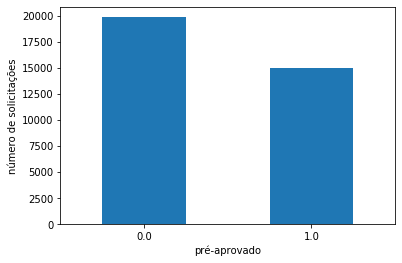

In [4]:
pre_aprovados = dataset.pre_approved.value_counts()

pre_aprovados.plot.bar(rot=0)

plt.ylabel('número de solicitações')
plt.xlabel('pré-aprovado');

In [5]:
print('Solicitações pré-aprovadas:', pre_aprovados[1])

Solicitações pré-aprovadas: 14998


<a id='dataprep'></a>

## Pré-processamento, limpeza, e remoção de dados

[topo](#home)

In [6]:
publico = dataprep(dataset)

In [7]:
""" Sumário do pré-processamento
"""

print(f'   {"coluna":>25} {"tipo":>10} {"unicos":>10} {"nulos":>10}')
      
for i, col in enumerate(publico.columns):
    col_dtype = str(publico[col].dtype)
    col_count = publico[col].nunique()
    col_nulos = publico[col].isna().sum()
    print(f'{i+1:>2} {col:>25} {col_dtype:>10} {col_count:>10} {col_nulos:>10}')

                      coluna       tipo     unicos      nulos
 1                        id      int64      10091          0
 2                       age      int64         69          0
 3            monthly_income    float64        991          0
 4               loan_amount    float64        870          0
 5                     state      int64         27          0
 6      verified_restriction      int64          3          0
 7         dishonored_checks      int64          2          0
 8             expired_debts      int64          2          0
 9             banking_debts      int64          2          0
10          commercial_debts      int64          2          0
11                  protests      int64          2          0
12      informed_restriction      int64          3          0
13           monthly_payment    float64       2006          0
14          informed_purpose     object       6485          0
15                auto_brand      int64         45          0
16      

<a id='modelo'></a>

## Modelos de classificação

[topo](#home)

In [8]:
""" Amostras de treino, teste e validação
"""

target = 'sent_to_analysis'

y = publico[target]
X = publico.drop(target, axis=1)

X_train, X_teste, y_train, y_teste = train_test_split(
    X, y, test_size=0.5, random_state=42)

X_teste, X_valid, y_teste, y_valid = train_test_split(
    X_teste, y_teste, test_size=0.5, random_state=42)

print('train:', X_train.shape)
print('teste:', X_teste.shape)
print('valid:', X_valid.shape)

train: (5045, 24)
teste: (2523, 24)
valid: (2523, 24)


<a id='texto'></a>

### Modelo de processamento de texto

[topo](#home)

In [9]:
%%time

X_train_obj = X_train.informed_purpose
X_teste_obj = X_teste.informed_purpose
X_valid_obj = X_valid.informed_purpose

vectorizer = bag_of_words(X_train_obj)

X_train_vec = vectorizer.transform(X_train_obj)
X_teste_vec = vectorizer.transform(X_teste_obj)
X_valid_vec = vectorizer.transform(X_valid_obj)

CPU times: user 590 ms, sys: 2.24 ms, total: 592 ms
Wall time: 591 ms


In [10]:
%%time

mnb = MultinomialNB()

mnb.fit(X_train_vec, y_train)

mnb_score_teste = mnb.predict_proba(X_teste_vec)[:, 1]
mnb_score_valid = mnb.predict_proba(X_valid_vec)[:, 1]

CPU times: user 0 ns, sys: 3.77 ms, total: 3.77 ms
Wall time: 2.84 ms


<a id='numer'></a>

### Modelo para as variáveis numéricas

[topo](#home)

In [11]:
X_train_num = X_train.select_dtypes(include=['float64'])
X_teste_num = X_teste.select_dtypes(include=['float64'])
X_valid_num = X_valid.select_dtypes(include=['float64'])

In [12]:
scaler = StandardScaler()

scaler.fit(X_train_num)

X_train_num_norm = scaler.transform(X_train_num)
X_teste_num_norm = scaler.transform(X_teste_num)
X_valid_num_norm = scaler.transform(X_valid_num)

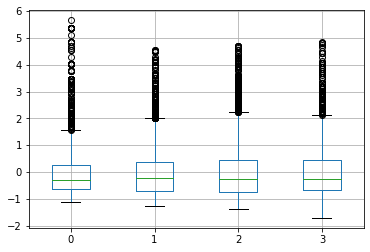

In [13]:
pd.DataFrame(X_train_num_norm).boxplot();

In [14]:
%%time

gnb = GaussianNB()

gnb.fit(X_train_num_norm, y_train)

gnb_score_teste = gnb.predict_proba(X_teste_num_norm)[:, 1]
gnb_score_valid = gnb.predict_proba(X_valid_num_norm)[:, 1]

CPU times: user 3.22 ms, sys: 0 ns, total: 3.22 ms
Wall time: 2.61 ms


<a id='categ'></a>

### Modelo para as variáveis categóricas

[topo](#home)

In [15]:
X_train_cat = X_train.select_dtypes(include=['int64'])
X_teste_cat = X_teste.select_dtypes(include=['int64'])
X_valid_cat = X_valid.select_dtypes(include=['int64'])

In [16]:
%%time

dtr = DecisionTreeClassifier(max_depth=5)

dtr.fit(X_train_cat, y_train)

dtr_score_teste = dtr.predict_proba(X_teste_cat)[:, 1]
dtr_score_valid = dtr.predict_proba(X_valid_cat)[:, 1]

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.6 ms


<a id='stack'></a>

### Stacking de modelos

[topo](#home)

In [17]:
X_teste_stack = np.c_[mnb_score_teste, gnb_score_teste, dtr_score_teste]
X_valid_stack = np.c_[mnb_score_valid, gnb_score_valid, dtr_score_valid]

In [18]:
%%time

clf = LogisticRegression(random_state=42, solver='lbfgs')

clf.fit(X_teste_stack, y_teste)

clf_score_valid = clf.predict_proba(X_valid_stack)[:, 1]

CPU times: user 3.95 ms, sys: 0 ns, total: 3.95 ms
Wall time: 3.66 ms


<a id='avalia'></a>

## Avaliação da solução

[topo](#home)

In [19]:
mnb_auc = roc_auc_score(y_valid, mnb_score_valid)
gnb_auc = roc_auc_score(y_valid, gnb_score_valid)
dtr_auc = roc_auc_score(y_valid, dtr_score_valid)
clf_auc = roc_auc_score(y_valid, clf_score_valid)

print('Multinomial Naive Bayes:', mnb_auc)
print('Gaussian Naive Bayes:', gnb_auc)
print('Decision Tree:', dtr_auc)
print('Stacking:', clf_auc)

Multinomial Naive Bayes: 0.6224858010057657
Gaussian Naive Bayes: 0.6252175687052274
Decision Tree: 0.7232668102491
Stacking: 0.7452969866626725


<a id='importance'></a>

## Importância das variáveis

[topo](#home)